# Load External Dependencies
TODO: 
- Environment: (Consider scripting this in, esp. if I move it into colab)
    - All the imports should be in this section
- Data: move all paths up here, and a test to ensure the datasets load
    - Training Data: I won't be making this data public. There is too much, and most of it is not mine to share.
        - Custom Data: I highly encourage checking how well this generalizes!
    - Evaluation Data: I will include a couple of sample images in the repo, so that anyone can load the model and run with it
- Trained Models: 
    - TODO: I need to add these in a convenient way
        -This was created as a proof of concept, so I've got a mess of dependencies and local paths to clean up
- Re-think some naming conventions throughout this doc
- clean up the display images (lots of redundancy that was helpful during dev, but confusing now)
    - improve labels
- improve the TF implementations
    - could be a lot cleaner with built in train and eval functions

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split # simpler to re-write and save a dependency

import scipy
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

import glob
import time
import random

# Configuration (Hyperparameters)
Since this is a notebook, it makes a lot of sense to play around with parameters defined just above where they are used, to enable fast iteration. However, it is also much easier to manage configuration in one place. 
Set `use_local = False` in order to use the parameters listed in this top conifg.
Set `use_local = True` to rely on parameters defined throughout this notebook.

# TODO: 
 - Many of the params have been moved here...some are still scattered throughout - Be more rigorous about where parameters are located

In [2]:
use_local = True

# Data Parameters:
base_dir = r"C:\Users\OptimizePrime\Desktop\TrevorStuff\LargeFiles\DataSets_TooBigForProjectRepos\WeldImages\ClevisWeld"
passing_images_dir = os.path.join(base_dir, "Fail")
anomaly_images_dir = os.path.join(base_dir, "Pass")

### Pre-Process Parameters:

# Crop: Optionally, use this to focus in a key area of interest, or set to None to avoid cropping
top = 0
bottom = 255
left = 50
right = -25
# crop_dims = (top, bottom, left, right)
crop_dims = None


### Model Parameters:
dsize = (256, 256)

### Post-Process Parameters:

In [3]:
def validate_image_dir(src_dir, rich_print=True):
    """
    Purpose: Perform basic validation that the directory is valid.
    Considered valid if the directory contains at least 1 file. 
    Does NOT check extensions to verify files are images
    
    inputs:
        src_dir (string): directory to validate
        rich_print (bool): Whether to print a msg summarizing validation
    """
    good_image_paths = glob.glob(src_dir + '\*' )
    assert(len(good_image_paths) != 0)
    if rich_print:
        print(f"Found {len(good_image_paths)} files in in directory:\n{src_dir}")

if use_local:
    validate_image_dir(passing_images_dir)
    validate_image_dir(anomaly_images_dir)

Found 147 files in in directory:
C:\Users\OptimizePrime\Desktop\TrevorStuff\LargeFiles\DataSets_TooBigForProjectRepos\WeldImages\ClevisWeld\Fail
Found 146 files in in directory:
C:\Users\OptimizePrime\Desktop\TrevorStuff\LargeFiles\DataSets_TooBigForProjectRepos\WeldImages\ClevisWeld\Pass


All external dependencies should be loaded (so hopefully it's smooth sailing from here).

# Image Processing Tools

TODO: Consider Moving "Tools" into 1 or more separate python files, and importing

In [4]:
def binarize(image, thresh):
    """ 
    Creates a copy of the images, with binary thresholding. The return image will set
    pixels above 'thresh' to 'value'. 
    Original image will not be modified.
    
    Inputs:
        image: src image that threshold image will be based on
        thresh: image will be thresholded based on this value.
        value: All pixels below the thresh are set to 0, pixels above the thresh are set to value
        
    return:
        image: The return image will be a binary threshold of the input image, based on thresh
    """
    image = image.copy()
    
    idx = (image[:,:] < thresh)
    image[idx] = 0
    
    idx = (image[:,:] > thresh)
    image[idx] = 1
    
    return image

In [5]:
# Only used for graphing at the moment - nifty, but it should only be called in the graph method, and 
# I should just be moving the viewing area, not changing the data
def limit(image, limits):
    image = image.copy()
    lower, upper = limits
    
    if lower:
        idx = (image[:,:] < lower)
        image[idx] = lower
        
    if upper:
        idx = (image[:,:] > upper)
        image[idx] = upper
    
    return image

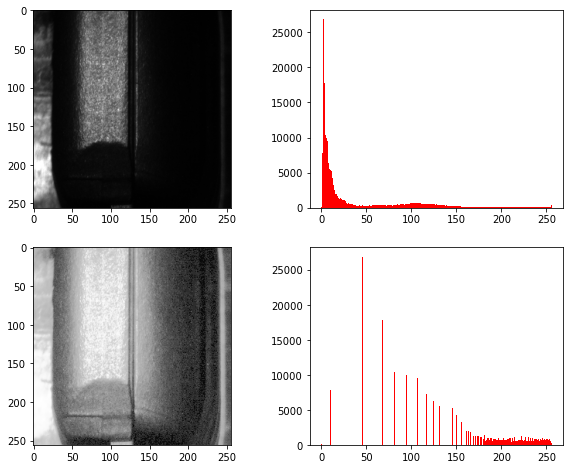

34.919830322265625
132.48060607910156


In [6]:
# Other Links of interest (adaptive threshold and histogram equalization)
# https://en.wikipedia.org/wiki/Adaptive_histogram_equalization
# https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

# Huge thanks to: https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
# Note that we won't bother to record this hist, so we won't be able to restore the original (and that's totally fine)
def equalize_histogram(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf2 = np.ma.filled(cdf_m,0).astype('uint8')
    equalized_img = cdf2[img]
    return equalized_img

########## test ###########
# Create Image/Hist
dsize = (256, 256)
index = 5
test_img = [ cv2.resize(cv2.imread(image_path), dsize) for image_path in glob.glob(passing_images_dir + '\*' )[index: index+1]][0]
eq_img = equalize_histogram(test_img)

# Display result
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8) )
ax00, ax01, ax10, ax11 = axes.flatten()

ax00.imshow(test_img)
ax01.hist(test_img.flatten(),256,[0,256], color = 'r')

ax10.imshow(eq_img)
ax11.hist(eq_img.flatten(),256,[0,256], color = 'r')
plt.show()

print(np.mean(test_img))
print(np.mean(eq_img))

# TODO:
- Arguably too simple of a function...I think it just makes things more confusing. consider removing

# Display Tools

In [7]:
def show_image_grid(images, labels = None, intensity_range = None, im_size=1):
    """
    Purpose:
        Helper function for displaying multiple images together in a grid.
    
    Inputs:
        images: A grid of images (list of list of images, or 4D numpy array of [n_rows, n_cols, im_height, im_width].
            The display shape will match the input shape. All rows are expected to be the same length.
        labels: A grid of labels (shape must match images).
        intensity_range: list of [vmin, vmax]
            - This is useful if you wish all plots to use the same intensity scale.
        im_size: This can be used to scale images down. Most useful with 1-4 images, when they tend to scale up.
            - Warning: values >1 will prevent some data from being displayed, because the image grid will be
                       larger than the plot size allotted.
    
    Return: None
    """        
    
    images = np.array(images)
        
    if(len(images.shape) != 4):
        print("Error: Input shape of images is not correct. Ensure input is 4D: n_rows, n_cols, im_height, im_width")
        return False
    
    if(im_size > 1):
        print("*"*100)
        print("Warning: im_size > 1 in call to 'show_image_grid'. Some images may not be displaying. Consider using im_size <= 1.")
        print("*"*100)
    im_size *= 6
    
    n_rows, n_cols, im_height, im_width = images.shape
    
    show_title = True
    if(labels is None):
        show_title = False
        labels = np.zeros((n_rows, n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(im_size*n_cols,im_size*n_rows)) # (20/n_images, 20/n_images))

    axs = np.array(axs).reshape(n_rows, n_cols)
    for ax_row, img_row, label_row in zip(axs, images, labels):
        for ax, img, label in zip(ax_row, img_row, label_row):
            if intensity_range is None:
                ax.imshow(img)
            else:
                ax.imshow(img, vmin = intensity_range[0], vmax = intensity_range[1])

            if(show_title):
                ax.set_title(label)
                ax.title.set_fontsize(3*im_size)
            
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

# Load Images

TODO: Consider moving the function in this section to their own python file (the configuration should stay here though)

In [8]:
def Read_and_preprocess_images(src_dir, dsize = (256, 256), crop_dims = None):
    """
    Purpose: Reading and preprocessing combined in one method because we're avoiding generators at the moment, and 
    some of the input images may be large. By reading and scaling down immediately, we can keep memory
    manageable. Long-term, I may convert to generator expressions, but that's really not the point of this
    excercise.
    
    Inputs:
        src_dir: Directory to read images from
        dsize: target image size to scale to
        crop_dims: (top, bottom, left, right)
    """
    print('Loading and pre-processing images...')
    t = time.time()
    
    # Read images
    images = [ cv2.resize(cv2.imread(image_path), dsize) for image_path in glob.glob(src_dir + '\*' )] 
    
#     # Resize: Done above (much faster if we never save the big version)
#     images = [cv2.resize(image, dsize) for image in images]
    
    # Grayscale
    images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]
    
    # Histogram Equalization
    images = [equalize_histogram(image) for image in images]
    
    # Normalize (scale into range(0->1))
    images = [image/256. for image in images]
    
    # Convert to numpy array
    images = np.array(images)
    
    # Crop
    if crop_dims is not None:
        images = [image[crop_dims[0]:crop_dims[1], crop_dims[2]:crop_dims[3]] for image in images]
     
    print(f"Preprocessing complete in {time.time() - t}s.")
    
    return images

In [9]:
nominal_all_images = Read_and_preprocess_images(passing_images_dir, dsize, crop_dims)
anomalous_all_images = Read_and_preprocess_images(anomaly_images_dir, dsize, crop_dims)

nominal_train_images, nominal_test_images = train_test_split(nominal_all_images, train_size=.8)

print("Shapes:")
print("nominal_all: ", nominal_all_images.shape)
print("anomalous_all: ", anomalous_all_images.shape)
print("nominal_train: ", nominal_train_images.shape)
print("nominal_test: ", nominal_test_images.shape)

Loading and pre-processing images...
Preprocessing complete in 7.897002220153809s.
Loading and pre-processing images...
Preprocessing complete in 8.0879967212677s.
Shapes:
nominal_all:  (147, 256, 256)
anomalous_all:  (146, 256, 256)
nominal_train:  (117, 256, 256)
nominal_test:  (30, 256, 256)


In [10]:
# Select images to demo in this notebook
nominal_index = random.randrange(0, len(nominal_test_images))
nominal_img = nominal_test_images[nominal_index]

anomalous_index = random.randrange(0, len(anomalous_all_images))
anomalous_img = anomalous_all_images[anomalous_index]

# Comparing Histograms of nominal / anomalous

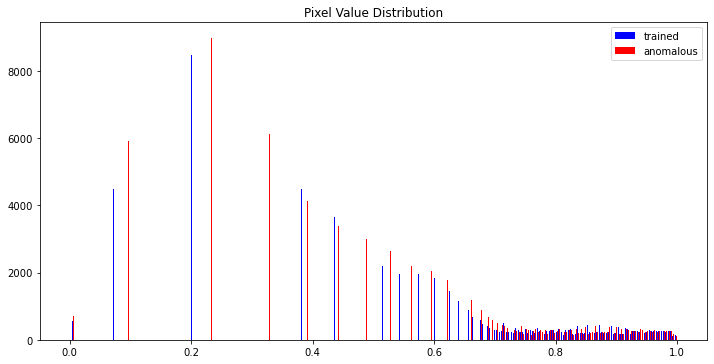

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5) )
fig.tight_layout()

def plot_hist(ax, data, title):
    colors=['blue','red']
    labels=["trained", "anomalous"]
    x_range = np.linspace(0, 1, 256)
    ax.hist(data, x_range, histtype='bar', color=colors, label=labels)
    ax.set_title(title)
    ax.legend(prop={'size': 10})

data = [nominal_img.flatten(), anomalous_img.flatten()]
title = "Pixel Value Distribution"
plot_hist(axes, data, title)
plt.show()

### Visualize data (this is a manual sanity check):
- Types of data:
    - First row is passing data (unwelded - just clean metal).
    - Second row is welded, as our 'anomaly' in this case will be the weld itself.
- Pre-Processing being demonstrated (by column)
    - First column is raw image data, just to show we've read the grayscale images correctly
    - Second column contains normalized images (which should look "flat" in color space)
        - This would not be the best choice of normalization in general, at it greatly increases the decreases the model's robustness to translation. 
        - This tequnique happened to work well on this particular dataset, because of poor lighting/hot spots. I started trying to justify it, but I think I just need to go back and adjust the methodology. It happened to work well here, but generally would not.
    - Third column is a restored image, demonstrating that we've reversed the normalization correctly (it should look identical to the first column

# Model
- We won't be regularizing, since we're actually attempted to overfit to some extent

In [12]:
# Note: Default init is glorot_uniform, bias=zeros
model = Sequential([
    layers.BatchNormalization(input_shape = (256, 256, 1)),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="conv1"),
    layers.MaxPooling2D((2, 2), padding="same", name="pool1"),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="conv2"),
    layers.MaxPooling2D((2, 2), padding="same", name="pool2"),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="conv3"),
    layers.MaxPooling2D((2, 2), padding="same", name="pool3"),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="conv4"),
    layers.MaxPooling2D((2, 2), padding="same", name="pool4"),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="conv5"),
    layers.MaxPooling2D((2, 2), padding="same", name="pool5"),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same", name="convTrans5"),
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same", name="convTrans4"),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same", name="convTrans3"),
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same", name="convTrans2"),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same", name="convTrans1"),
    layers.BatchNormalization(),
    layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same", name="Channel_Reducer")
    ], name="AutoEncoder")

# Train

TODO: 
    - This section has some nice manual methods...it's just that there's such clean ones already built-in,
consider switching over...It will make: this cleaner, the output cleaner, easier to add callbacks and metrics, etc.
    - Consider adding saving along the way, either periodically, or for best, and maybe add early stopping (with a high-ish patience)

TODO: Isn't this preprocessing? Why do I have it here?

In [13]:
# Optimizer can be reset without resetting entire model (momentum for Adam will reset though)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # .002 is 'sometimes' stable, meaing not really stable

model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy())
#                   loss=tf.keras.losses.MeanSquaredError())

In [14]:
# keras.utils.plot_model(model,
#                        show_shapes=True)
model.summary()

Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 256, 256, 1)      4         
 ormalization)                                                   
                                                                 
 conv1 (Conv2D)              (None, 256, 256, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 128, 128, 32)      0         
                                                                 
 conv2 (Conv2D)              (None, 128, 128, 32)      9248      
                                                                 
 pool2 (MaxPooling2D)        (None, 64, 64, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                       

Rather than using plotting a test set, we're going to plot the anomalous image set.
In this case we want excessive overfitting, so that we can start to differentiate anomalous images.

In [15]:
# tf.config.run_functions_eagerly(True)
model_name = "trained_with_batch_norm"
epochs = 200 # 5-8 epochs to show any intelligence, at least 30 for decent results, probably 75 for "good" numbers
batch_size = 32
test_data = (np.expand_dims(nominal_test_images, -1), np.expand_dims(nominal_test_images, -1))
anomalous_data = (np.expand_dims(anomalous_all_images, -1), np.expand_dims(anomalous_all_images, -1))

training_hist = model.fit(x = np.expand_dims(nominal_train_images, -1),
                          y = np.expand_dims(nominal_train_images, -1),
                          epochs=epochs,
                          batch_size = batch_size,
                          shuffle=True,
                          validation_data=anomalous_data)

Epoch 1/200
4/4 [==============================] - 30s 7s/step - loss: 0.7771 - val_loss: 0.6929
Epoch 2/200
4/4 [==============================] - 27s 7s/step - loss: 0.6441 - val_loss: 0.6926
Epoch 3/200
4/4 [==============================] - 26s 7s/step - loss: 0.6129 - val_loss: 0.6923
Epoch 4/200
4/4 [==============================] - 28s 8s/step - loss: 0.5968 - val_loss: 0.6921
Epoch 5/200
4/4 [==============================] - 27s 7s/step - loss: 0.5867 - val_loss: 0.6921
Epoch 6/200
4/4 [==============================] - 29s 8s/step - loss: 0.5793 - val_loss: 0.6922
Epoch 7/200
4/4 [==============================] - 30s 8s/step - loss: 0.5731 - val_loss: 0.6924
Epoch 8/200
4/4 [==============================] - 30s 8s/step - loss: 0.5673 - val_loss: 0.6926
Epoch 9/200
4/4 [==============================] - 28s 8s/step - loss: 0.5627 - val_loss: 0.6926
Epoch 10/200
4/4 [==============================] - 28s 7s/step - loss: 0.5592 - val_loss: 0.6925
Epoch 11/200
4/4 [===========

4/4 [==============================] - 23s 6s/step - loss: 0.5401 - val_loss: 0.6251
Epoch 85/200
4/4 [==============================] - 23s 6s/step - loss: 0.5401 - val_loss: 0.6224
Epoch 86/200
4/4 [==============================] - 22s 6s/step - loss: 0.5401 - val_loss: 0.6160
Epoch 87/200
4/4 [==============================] - 22s 6s/step - loss: 0.5401 - val_loss: 0.6144
Epoch 88/200
4/4 [==============================] - 23s 6s/step - loss: 0.5401 - val_loss: 0.6143
Epoch 89/200
4/4 [==============================] - 21s 6s/step - loss: 0.5401 - val_loss: 0.6122
Epoch 90/200
4/4 [==============================] - 22s 6s/step - loss: 0.5400 - val_loss: 0.6076
Epoch 91/200
4/4 [==============================] - 21s 6s/step - loss: 0.5400 - val_loss: 0.6059
Epoch 92/200
4/4 [==============================] - 23s 6s/step - loss: 0.5399 - val_loss: 0.6029
Epoch 93/200
4/4 [==============================] - 23s 6s/step - loss: 0.5399 - val_loss: 0.6001
Epoch 94/200
4/4 [===============

4/4 [==============================] - 21s 6s/step - loss: 0.5390 - val_loss: 0.5449
Epoch 168/200
4/4 [==============================] - 22s 6s/step - loss: 0.5390 - val_loss: 0.5450
Epoch 169/200
4/4 [==============================] - 22s 6s/step - loss: 0.5390 - val_loss: 0.5449
Epoch 170/200
4/4 [==============================] - 22s 6s/step - loss: 0.5389 - val_loss: 0.5450
Epoch 171/200
4/4 [==============================] - 22s 6s/step - loss: 0.5390 - val_loss: 0.5454
Epoch 172/200
4/4 [==============================] - 21s 6s/step - loss: 0.5390 - val_loss: 0.5449
Epoch 173/200
4/4 [==============================] - 21s 6s/step - loss: 0.5390 - val_loss: 0.5447
Epoch 174/200
4/4 [==============================] - 22s 6s/step - loss: 0.5390 - val_loss: 0.5448
Epoch 175/200
4/4 [==============================] - 21s 6s/step - loss: 0.5389 - val_loss: 0.5448
Epoch 176/200
4/4 [==============================] - 22s 6s/step - loss: 0.5389 - val_loss: 0.5448
Epoch 177/200
4/4 [=====

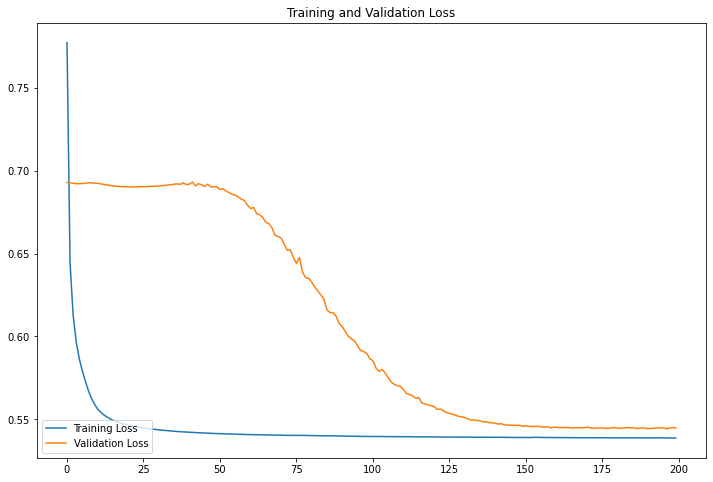

In [16]:
loss = training_hist.history['loss']
val_loss = training_hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12,8))


# plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

# Save and Load

In [17]:
save_path = os.path.join("models/", model_name)
model.save(save_path) # I've got a decent model saved already

INFO:tensorflow:Assets written to: models/trained_with_batch_norm\assets


In [18]:
model_name = None # generally, don't overwrite the trained model unless we explicitly set the model to load
if model_name is not None:
    load_path = os.path.join("models/", model_name)
    model = tf.keras.models.load_model(model_name)
    model.summary()

# Apply model and post-process results

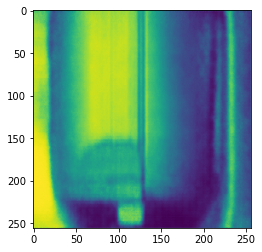

In [19]:
def predict(model, pred_image):
    """
    Calls model / model.predict on a single image. 
    Inputs:
        model: A trained TF model, expecting data of the form: [n_images, row, col, channel]
        pred_image: An image with dims: [row, col]
    return:
        image (with dims: [row, col])
Expects dims: [batch, row, col, channel], and strips 
    """
    im_with_dims = np.expand_dims(np.expand_dims(pred_image, 0), -1) # add 1 in the n_images and channel dims
    return model.predict(im_with_dims)[0,:,:,0] # strip n_images and channel dims

# Test
plt.imshow(predict(model, nominal_img))

TODO:
- Looking back at this, the reconstruction picks up 2 things:
    - All high frequency information (makes sense, since my resizing/pooling destroys that anyways)
    - All unique features (eg: the welds)
- Consider leveraging the fact that all high frequency information is detected...
    - maybe pre-process with a low-pass filter(or just resize down to 256 for a similar effect)
    - I'm already doing an erode+dilate, but it's post-processing, and not quite the right way to ignore noise
- Again, using 4 samples, which was nice in dev, but kind of confusing to anybody else reading through now

## Visualize Sample Image

In [20]:
def find_loss_image(image1, image2): 
    height, width = image1.shape
    loss_image = tf.losses.mean_squared_error(image1.reshape(height, width, 1), image2.reshape(height, width, 1)).numpy()
    return loss_image

In [21]:
# Filter out salt and pepper noise
# This model downsamples, losing most the high frequency components...so a little denoising is needed
# This is a quick way to do that
def remove_salt_and_pepper_noise(image, kernel_dims=(3,3), iterations=1):
    kernel = np.ones(kernel_dims, np.uint8)
#     print(f"removing salt_and_pepper: {kernel_dims}")
    eroded = cv2.erode(image, kernel, iterations=iterations)
    smoothed = cv2.dilate(eroded, kernel, iterations=iterations)
    return smoothed



# TODO: Denoising improvements
- could try this builtin cv2 func: new = cv2.fastNlMeansDenoising(trained_loss[0])

# Demonstrate key feature extraction with loss function
- Notably, there were a few other tequniques that worked well, and that I would have investigated more if this project had continued:
    - using division (which scales for brightness quite well)
    - absdiff (basically MAE)
- I also played with dynamic thresholding a bit, but in the end, I couldn't be sure my thresholds would generalize, because noise distributions might be different; however, for this application, the snippet below worked well.
```
trained_loss_flat = sorted(trained_loss[0].flatten())
thresh = trained_loss_flat[-10]
print("Thresh", thresh)
```

(256, 256) (256, 256) (256, 256)


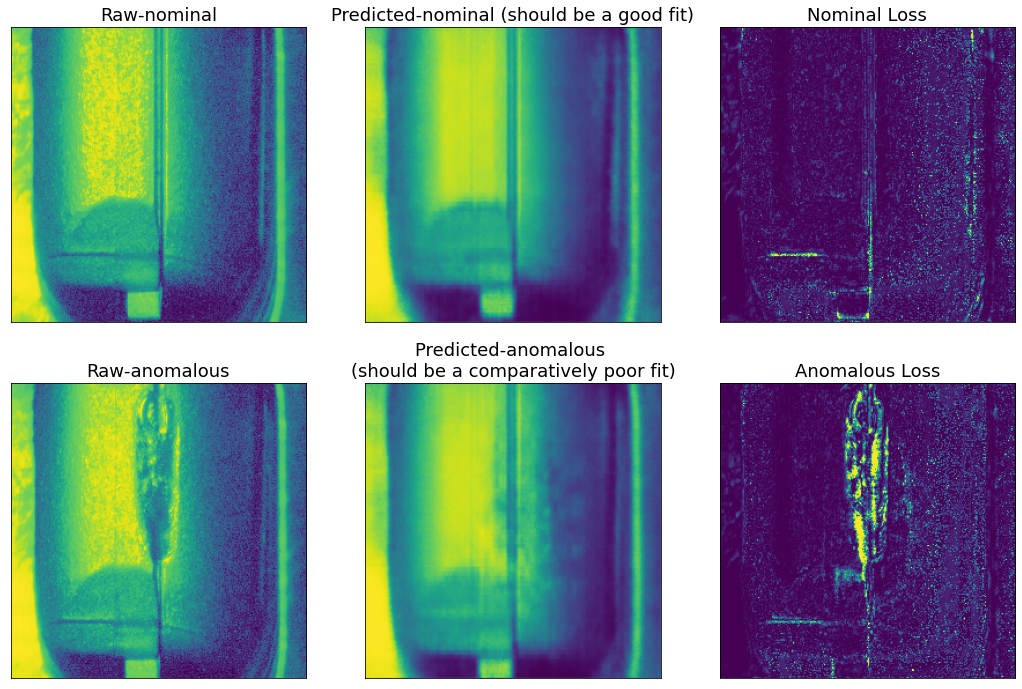

In [22]:
pred_nom_img = predict(model, nominal_img)
nom_loss = find_loss_image(nominal_img, pred_nom_img)

pred_anom_img = predict(model, anomalous_img)
anom_loss = find_loss_image(anomalous_img, pred_anom_img)



label_grid = [["Raw-nominal", "Predicted-nominal (should be a good fit)", "Nominal Loss"],
             ["Raw-anomalous", "Predicted-anomalous \n(should be a comparatively poor fit)", "Anomalous Loss"]]
print(nominal_img.shape, pred_nom_img.shape, nom_loss.shape)
# Sanity check to make sure the images are sensible
y_max = 1
image_grid = np.array([[limit(nominal_img, (None, y_max)),
                        limit(pred_nom_img, (None, y_max)), 
                        limit(nom_loss, (None, y_max/20.))], 
                       [limit(anomalous_img, (None, y_max)), 
                        limit(pred_anom_img, (None, y_max)), 
                        limit(anom_loss, (None, y_max/20.))]])
show_image_grid(image_grid, label_grid)

# The plot below shows is beginning to show differences in the distributions
# we can create a metric that clearly distinguishes between distributions

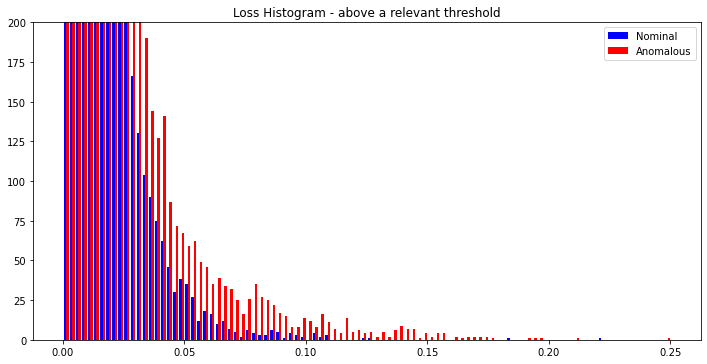

In [23]:
# Plot
# Reference: 
# https://matplotlib.org/2.0.2/examples/statistics/histogram_demo_multihist.html
# https://matplotlib.org/stable/plot_types/stats/hist2d.html?highlight=y%20range

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5) )
# ax0, ax1 = axes.flatten()
ax1 = axes 

fig.tight_layout()
data = [nom_loss.flatten(), anom_loss.flatten()]

colors = ['blue', 'red']
labels = ["Nominal", "Anomalous"]

bins = 100 # np.linspace(xmin, xmax, 30)
ax1.hist(data, bins, histtype='bar', color=colors, label=labels)
# ax1.hist(data, np.linspace(thresh/2, thresh, 30), histtype='bar', color=colors, label=labels)
ax1.set_title('Loss Histogram - above a relevant threshold')
ax1.legend(prop={'size': 10})
# ax1.set(xlim=(xmin, xmax))
ax1.set(ylim=(0, 200))

plt.show()

In [24]:
def denoise(bin_image, min_cluster_size = 5):
    """
    Runs in O(n), where n is the number of pixels in the image.
    I explored some other tools, like erode / dilate, and a few others, but this is working well for now.
    """
    height,width = bin_image.shape #256, 256
    image = bin_image.copy().flatten() # Create a copy (so we don't mess up the original)

    # initialize the visited array (0 for unvisited, -1 for unvisitable, aka bin_image is already 0 there)
    UNEXPLORED = -1
    IMAGE_0 = -2
    visited = np.ones(image.shape)*IMAGE_0# nothing explored yet
    idx = (image[:] != 0)
    visited[idx] = UNEXPLORED

    for search_index in range(image.shape[0]):
        # print(f"{search_index}/{image.shape[0]}")
        frontier = set([search_index]) # initialize with current item
        this_cluster = []
        pixels_in_cluster = 0
        while frontier:
            # print(f"Frontier: {frontier}")
            pixel_index = frontier.pop()
            if visited[pixel_index] == UNEXPLORED:
                visited[pixel_index] = search_index # set the group ID of this pixel to the index that started this DFS
                pixels_in_cluster += 1

                # Add the graph's edges
                if pixel_index >= width:  # up
                    frontier.add(pixel_index - width)
                if pixel_index < width * (height - 1):  # down
                    frontier.add(pixel_index + width)
                if pixel_index % width != 0:  # left
                    frontier.add(pixel_index - 1)
                if pixel_index % width != (width - 1):  # right
                    frontier.add(pixel_index + 1)

                this_cluster.append(pixel_index)

        if pixels_in_cluster < min_cluster_size:
            image[this_cluster] = 0

    return image.reshape(height,width)

In [25]:
def post_process(pre_img, predicted_im, thresh, min_pixels_per_cluster): 
    loss_im = find_loss_image(pre_img, predicted_im)
    bin_img = binarize(loss_im, thresh)
    denoised_image = denoise(bin_img, min_pixels_per_cluster)
#     denoised_image = remove_salt_and_pepper_noise(denoised_image, kernel_dims = (20,3))
    return denoised_image

In [26]:
thresh = 0.02
min_pixels_per_cluster = 10

Loss on trained image: 0.0052
Loss on unfit image: 0.0281
{v}: Unfit image missed 5.38 times as much information.
0.22062947


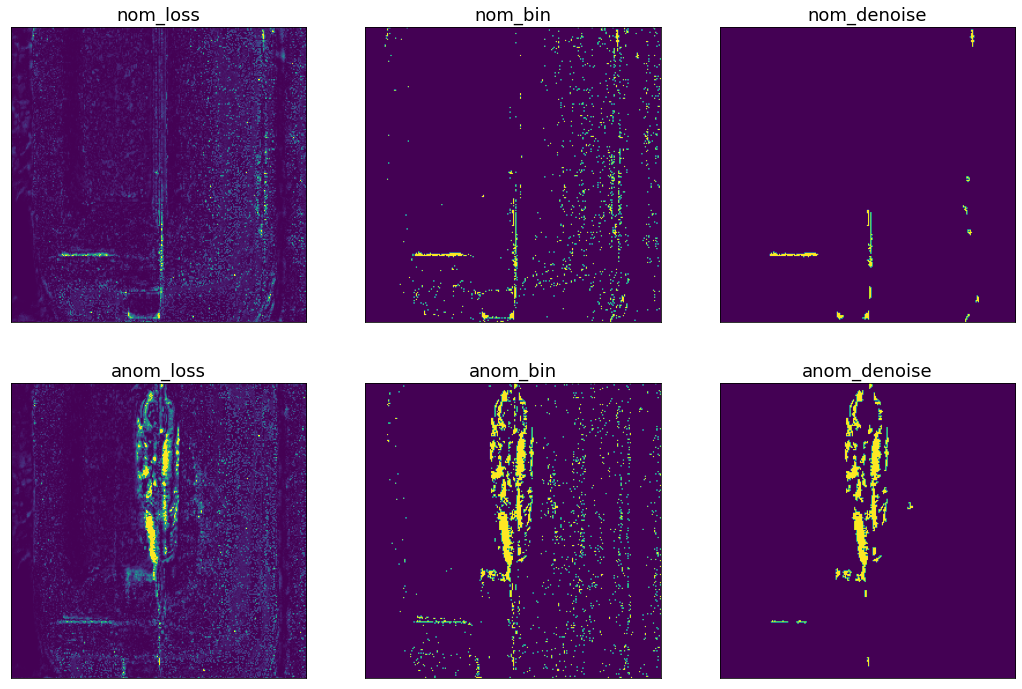

In [27]:
pred_nom_img = predict(model, nominal_img)
nom_loss = find_loss_image(nominal_img, pred_nom_img)
nom_bin = binarize(nom_loss, thresh)
nom_denoise = denoise(nom_bin, min_pixels_per_cluster)
# nom_denoise = fill_holes(nom_denoise, kernel_dims = (1,10))

pred_anom_img = predict(model, anomalous_img)
anom_loss = find_loss_image(anomalous_img, pred_anom_img)
anom_bin = binarize(anom_loss, thresh)
anom_denoise = denoise(anom_bin, min_pixels_per_cluster)
# anom_denoise = fill_holes(anom_denoise, kernel_dims = (1,10))

###########################################################################

image_grid = [[nom_loss*15., nom_bin, nom_denoise],
              [anom_loss*15., anom_bin, anom_denoise]]

label_grid = [["nom_loss", "nom_bin", "nom_denoise"],
              ["anom_loss", "anom_bin", "anom_denoise"]]

print("Loss on trained image: %0.4f" %  np.mean(nom_denoise))
print("Loss on unfit image: %0.4f" % np.mean(anom_denoise))
print("{v}: Unfit image missed %0.2f times as much information." % (np.mean(anom_denoise)/np.mean(nom_denoise)) ) 
    
show_image_grid(image_grid, label_grid, intensity_range=(0, 1)) 
print(np.max(nom_loss))

# TODO
Add a set of images for nom and anom showing
- loss image
- Thresholded loss image
- Thresholded loss image with denoising

# Show extracted pixels overlaid on top of original

Loss on trained image: 0.0052
Loss on unfit image: 0.0281
Unfit image missed 5.38 times as much information.


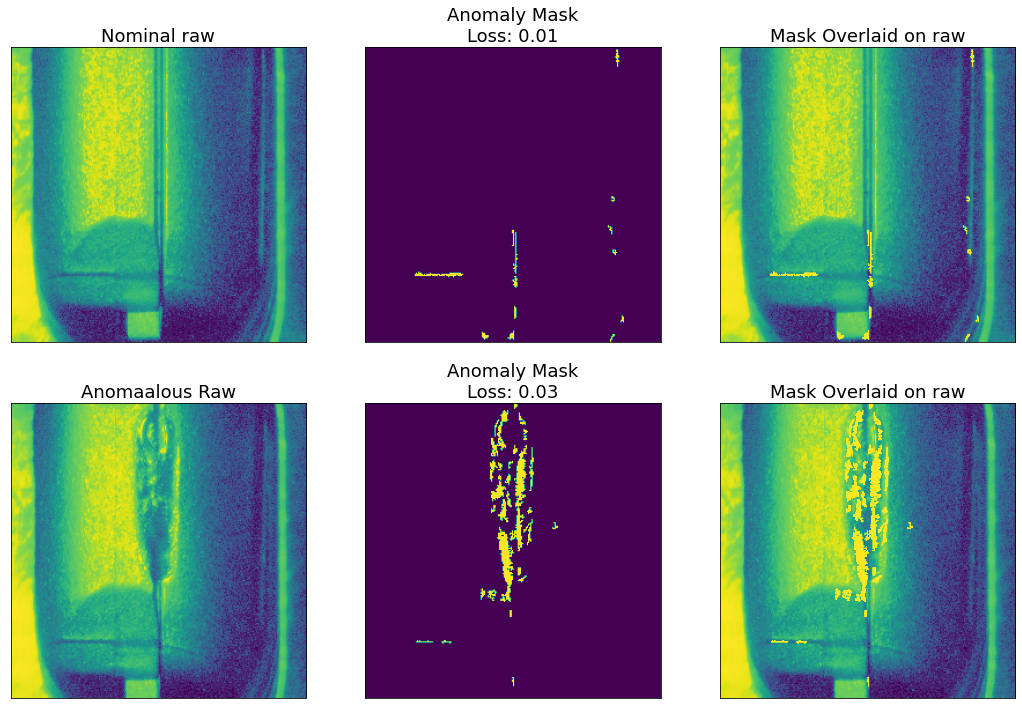

In [28]:
post_nom_im = post_process(nominal_img, pred_nom_img, thresh, min_pixels_per_cluster)
post_anom_im = post_process(anomalous_img, pred_anom_img, thresh, min_pixels_per_cluster)

# print(post_trained_im[0].shape)
trained_mean_loss = np.mean(post_nom_im)
anomalous_mean_loss = np.mean(post_anom_im)

image_grid = [[nominal_img, post_nom_im, nominal_img+post_nom_im],
              [anomalous_img, post_anom_im, anomalous_img+post_anom_im]]

label_grid = [["Nominal raw", "Anomaly Mask\nLoss: %0.2f" % trained_mean_loss, "Mask Overlaid on raw"],
             ["Anomaalous Raw", "Anomaly Mask\nLoss: %0.2f" % anomalous_mean_loss, "Mask Overlaid on raw"]]

print("Loss on trained image: %0.4f" % trained_mean_loss)
print("Loss on unfit image: %0.4f" % anomalous_mean_loss)
print("Unfit image missed %0.2f times as much information." % (anomalous_mean_loss/trained_mean_loss) ) 

show_image_grid(image_grid, label_grid, intensity_range=(0, 1)) 


# Summary and Analysis (Averaged over entire dataset)

In [29]:
def process_images(pre_images, crop_dims=None):
    kernel_dims = (3,3)
    images_with_channel = np.expand_dims(pre_images, -1)
    print("pre_images (adjusted): ", images_with_channel.shape)
    
    predicted_images = model.predict(images_with_channel)
    print("pred_nom_images: ", predicted_images.shape)
    
    loss_images = tf.losses.mean_squared_error( np.expand_dims(pre_images, -1), predicted_images).numpy()
    print("loss_nom_images: ", loss_images.shape)
    
    bin_images = np.array([binarize(image, thresh) for image in loss_images])
    print("bin_nom_images: ", bin_images.shape)
    
    denoise_images = np.array([remove_salt_and_pepper_noise(image, kernel_dims) for image in bin_images])
    print("denoise_images ", denoise_images.shape)
    
    if crop_dims is not None:
        crop_images = np.array([image[top:bottom, left:right] for image in denoise_images])
    else:
        crop_images = denoise_images
    print("crop_images ", crop_images.shape)
        
    mean_loss = np.mean(crop_images, (1,2))
    print("Complete\n")
    
    return mean_loss 

nominal_loss_list = process_images(nominal_test_images)  
anomaly_loss_list = process_images(anomalous_all_images)

pre_images (adjusted):  (30, 256, 256, 1)
pred_nom_images:  (30, 256, 256, 1)
loss_nom_images:  (30, 256, 256)
bin_nom_images:  (30, 256, 256)
denoise_images  (30, 256, 256)
crop_images  (30, 256, 256)
Complete

pre_images (adjusted):  (146, 256, 256, 1)
pred_nom_images:  (146, 256, 256, 1)
loss_nom_images:  (146, 256, 256)
bin_nom_images:  (146, 256, 256)
denoise_images  (146, 256, 256)
crop_images  (146, 256, 256)
Complete



### Plot Resulting Distributions

C:\Users\OptimizePrime\anaconda3\envs\ml2\lib\site-packages\numpy\core\fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
C:\Users\OptimizePrime\anaconda3\envs\ml2\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


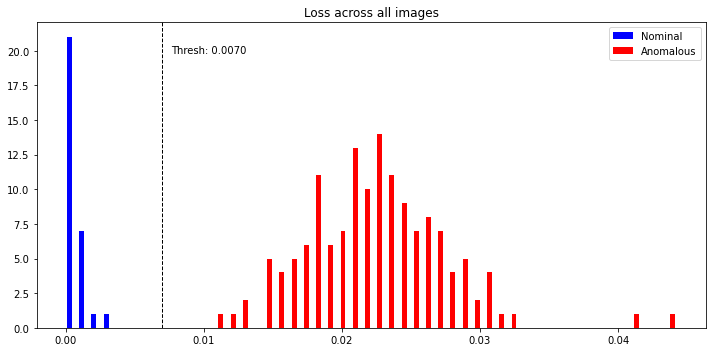

In [30]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax = axes # ax = axes.flatten()

data = [nominal_loss_list, anomaly_loss_list]
bins = 50
colors = ["blue","red"]
labels = ["Nominal", "Anomalous"]
ax.hist(data, bins, histtype='bar', color=colors, label=labels)


thresh = np.mean((np.max(nominal_loss_list),np.min(anomaly_loss_list)))
ax.axvline(thresh, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(thresh*1.1, max_ylim*0.9, 'Thresh: {:.4f}'.format(thresh))

ax.set_title('Loss across all images')
ax.legend(prop={'size': 10})

fig.tight_layout()

plt.show()



In [31]:
# Set a threshold 
# Used during development to find extreme images - this allowed me to tune the model
for i, v in enumerate(nominal_loss_list):
    if v > thresh:
        print("Bad Nominal: ", v, ":", i)
for i, v in enumerate(anomaly_loss_list):
    if v < thresh: 
        print("Bad anomalous: ", v, ":", i)

## How to set the threshold?
We have a lot of ways to evaluate the model, and the ideal threshold. We commonly try to summarize with a single value (such as F1 score, or area under the precision-recall curve, or a ROC curve. I'll look at a few of those below, but it quickly becomes obvious that they aren't very useful in applications that require extremely reliable detection of defects.

### Extrpolate distributions with statistics
In this example, we have __perfect__ characterization. That's very common with smaller sample sizes, and we will simply extrapolate using statistics, and using ratios with a cdf function.
__You should ensure all data are normal before performing this analysis__. Just eyeballing it, I can tell my data are not normally distributed, and would require a transform for their distribtuions to become normal. I may do that in the future, but for now, it's out of scope. Obviously, we'd perform a deeper analysis before actually relying on this.
[Learn more here](https://www.analyticsvidhya.com/blog/2021/05/how-to-transform-features-into-normal-gaussian-distribution/)

### Safety Critical Applications have different priorities
When it comes to safety critical applications, we're very concerned about escapes (false negatives). Escapes kill people, whereas False positives add a couple minutes of manual verification. Therefore, we'll set our threshold based on the anomalous group. We count standard deviations from the mean of the anomalous group. Best practices vary from 3-6 standard deviations, based on how critical a defect is, industry, and company policy. However, 4 is a good starting point, and that's what I'll use here.

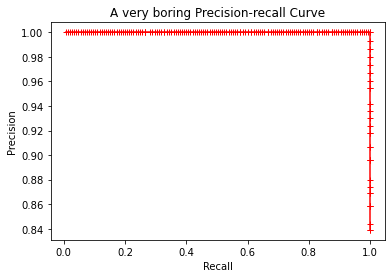

In [32]:
# Plot Raw Precision-Recall Curve
def generate_precision_recall_curve(negatives, positives):
    """
    This function assumes values above the threshold are positive, and values below the threshold are negative.
    """
    thresholds = sorted(list(negatives) + list(positives))
    
    precision = []
    recall = []
    for thresh in thresholds:
        true_pos = np.count_nonzero(positives > thresh)
        false_neg = np.count_nonzero(positives < thresh)
        false_pos = np.count_nonzero(negatives > thresh)
        if true_pos + false_pos != 0 and true_pos + false_neg != 0:
            precision.append(true_pos / (true_pos + false_pos) )
            recall.append(true_pos / (true_pos + false_neg) )
        
    plt.plot(recall, precision, 'r-+')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("A very boring Precision-recall Curve")
        
generate_precision_recall_curve(nominal_loss_list, anomaly_loss_list)

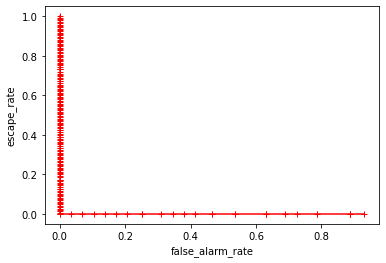

In [33]:
# escape rate vs. false alarm rate 
def generate_false_alarm_escape_curve(negatives, positives, threshold_samples):
    """
    This function assumes values above the threshold are positive, and values below the threshold are negative.
    """
    false_alarm_rate = []
    escape_rate = []
    for thresh in threshold_samples:
        true_pos = np.count_nonzero(positives > thresh)
        true_neg = np.count_nonzero(negatives < thresh)
        false_pos = np.count_nonzero(negatives > thresh)
        false_neg = np.count_nonzero(positives < thresh)
        
        false_alarm_rate.append(false_pos / (false_pos + true_neg))
        escape_rate.append(false_neg / (false_neg + true_pos))
        
    plt.plot(false_alarm_rate, escape_rate, 'r-+')
    plt.xlabel("false_alarm_rate")
    plt.ylabel("escape_rate")

        
thresholds = sorted(list(nominal_loss_list) + list(anomaly_loss_list))[2:]
generate_false_alarm_escape_curve(nominal_loss_list, anomaly_loss_list, thresholds)


escape_rate, false_alarm_rate
z_thresh: -4.00, thresh_val: 0.0024, x: 0.0032%, y: 0.49%
z_thresh: -3.80, thresh_val: 0.0034, x: 0.0072%, y: 0.00%
z_thresh: -3.60, thresh_val: 0.0044, x: 0.0159%, y: 0.00%
z_thresh: -3.40, thresh_val: 0.0054, x: 0.0337%, y: 0.00%
z_thresh: -3.20, thresh_val: 0.0064, x: 0.0687%, y: 0.00%
z_thresh: -3.00, thresh_val: 0.0074, x: 0.1350%, y: 0.00%

recall, precision
z_thresh: -4.00, thresh_val: 0.0024, x: 99.9968%, y: 99.51%
z_thresh: -3.80, thresh_val: 0.0034, x: 99.9928%, y: 100.00%
z_thresh: -3.60, thresh_val: 0.0044, x: 99.9841%, y: 100.00%
z_thresh: -3.40, thresh_val: 0.0054, x: 99.9663%, y: 100.00%
z_thresh: -3.20, thresh_val: 0.0064, x: 99.9313%, y: 100.00%
z_thresh: -3.00, thresh_val: 0.0074, x: 99.8650%, y: 100.00%


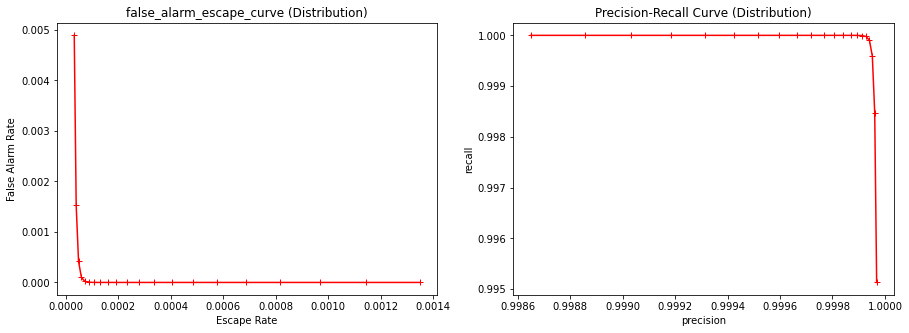

In [34]:
# escape rate vs. false alarm rate 
def precision(true_pos, true_neg, false_pos, false_neg):
    return true_pos / (true_pos + false_pos)
def recall(true_pos, true_neg, false_pos, false_neg):
    return true_pos / (true_pos + false_neg)
def sensitivity(true_pos, true_neg, false_pos, false_neg):
    return true_pos / (true_pos + false_neg)
# def specificity():
def false_alarm_rate(true_pos, true_neg, false_pos, false_neg):
    return false_pos / (false_pos + true_neg)
def escape_rate(true_pos, true_neg, false_pos, false_neg):
    return false_neg / (false_neg + true_pos)


def generate_sampled_gaussian_plot(negatives, positives, x_function, y_function):
    """
    This function assumes values above the threshold are positive, and values below the threshold are negative.
    """
    pos_mean = np.mean(positives)
    pos_std_dev = np.std(positives)
#     print(f"Distribution for positive (nominal) data: u={pos_mean}, sigma={pos_std_dev}")
    
    neg_mean = np.mean(negatives)
    neg_std_dev = np.std(negatives)
#     print(f"Distribution for negative (anomalous) data:  u={neg_mean}, sigma={neg_std_dev}")

    steps = 21
    z_threshholds = np.linspace(-4, -3, steps)
    
    x = []
    y = []
    print(f"\n{x_function.__name__}, {y_function.__name__}")
    for i, z_thresh in enumerate(z_threshholds):
#         z_pos = (thresh - pos_mean) / pos_std_dev
        true_pos = 1 - scipy.stats.norm.cdf(z_thresh)
        false_neg = 1 - true_pos 
        
        thresh_val = pos_mean + z_thresh*pos_std_dev
        z_neg = (thresh_val - neg_mean) / neg_std_dev
        true_neg = scipy.stats.norm.cdf(z_neg)
        false_pos = 1 - true_neg 
        
        x.append(x_function(true_pos, true_neg, false_pos, false_neg))
        y.append(y_function(true_pos, true_neg, false_pos, false_neg))
        if i %4 == 0:
            print(f"z_thresh: {z_thresh:.2f}, thresh_val: {thresh_val:.4f}, x: {x[-1]*100:.4f}%, y: {y[-1]*100:.2f}%")
        
    return x, y 

def plot_precision_recall_curve(negatives, positives, ax):
    x,y = generate_sampled_gaussian_plot(negatives, positives, recall, precision)
    ax.plot(x, y, 'r-+') #, cpk4_x, cpk4_y, 'bo')
    ax.set_xlabel("precision")
    ax.set_ylabel("recall")
    ax.set_title("Precision-Recall Curve (Distribution)")
    
def roc_curve(negatives, positives, ax):
    x,y = generate_sampled_gaussian_plot(negatives, positives, false_alarm_rate, sensitivity)
    ax.plot(x, y, 'r-+') # , cpk4_x, cpk4_y, 'bo')
    ax.set_xlabel("True Positive Rate")
    ax.set_ylabel("False Alarm Rate")
    ax.set_title("ROC Curve (Distribution)")
    
def false_alarm_escape_curve(negatives, positives, ax):
    x,y = generate_sampled_gaussian_plot(negatives, positives, escape_rate, false_alarm_rate)
    ax.plot(x, y, 'r-+') # , cpk4_x, cpk4_y, 'bo')
    ax.set_xlabel("Escape Rate")
    ax.set_ylabel("False Alarm Rate")
    ax.set_title("false_alarm_escape_curve (Distribution)")
    
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5) )
ax0, ax1 = axes.flatten()

false_alarm_escape_curve(nominal_loss_list, anomaly_loss_list, ax0)
plot_precision_recall_curve(nominal_loss_list, anomaly_loss_list, ax1)


Looking at the False Alarm vs. Escape, we can get a good idea of where to set the threshold for different applications.
- For safety critical tests: This detector is not ready for safety critical evaluation on this application 
    - We would set it to 4 standard deviations, missing only .0032% of escapes
    - However, we would be overwhelmed by a 56% False alarm rate!
    - Additional improvements needed
- For less critical tests (such as visual defects): This would be fantastic for less critical applications, finding visual defects
    - We could catch nearly 99.9% of issues, and only trigger false positives 0.02% of the time
    - Because this is a very general application, we can find defects anywhere in the image
- Offline assessment

### How to improve the model?
#### Low Hanging Fruit (crop)
For specific safety critical failures, we usually know exactly which failure we're looking for and where to find it. 
We trained this model on the nominal dataset only, and then treated the welded data as the defect. This is a bit artificial;
however, we can use it to show the extra power our model gains when we know exactly where to look.

The analysis below crops the welded region, focusing in just the spot we care about, and the numbers get **much** better.

#### Additional Improvements
- Augment Data: Primarily x and y offset, since the main errors the model still shows are in the slight offsets in extreme bright/dark transitions
- Increase the amount of training data
- Train longer (training had nearly plateaud, but we could probably get a little more performance, and we actively want a degree of overfitting, so there's no need to worry about that

pre_images (adjusted):  (30, 256, 256, 1)
pred_nom_images:  (30, 256, 256, 1)
loss_nom_images:  (30, 256, 256)
bin_nom_images:  (30, 256, 256)
denoise_images  (30, 256, 256)
crop_images  (30, 255, 181)
Complete

pre_images (adjusted):  (146, 256, 256, 1)
pred_nom_images:  (146, 256, 256, 1)
loss_nom_images:  (146, 256, 256)
bin_nom_images:  (146, 256, 256)
denoise_images  (146, 256, 256)
crop_images  (146, 255, 181)
Complete


escape_rate, false_alarm_rate
z_thresh: -4.00, thresh_val: 0.0185, x: 0.0032%, y: 0.06%
z_thresh: -3.80, thresh_val: 0.0209, x: 0.0072%, y: 0.00%
z_thresh: -3.60, thresh_val: 0.0234, x: 0.0159%, y: 0.00%
z_thresh: -3.40, thresh_val: 0.0258, x: 0.0337%, y: 0.00%
z_thresh: -3.20, thresh_val: 0.0283, x: 0.0687%, y: 0.00%
z_thresh: -3.00, thresh_val: 0.0307, x: 0.1350%, y: 0.00%

recall, precision
z_thresh: -4.00, thresh_val: 0.0185, x: 99.9968%, y: 99.94%
z_thresh: -3.80, thresh_val: 0.0209, x: 99.9928%, y: 100.00%
z_thresh: -3.60, thresh_val: 0.0234, x: 99.9841%, y

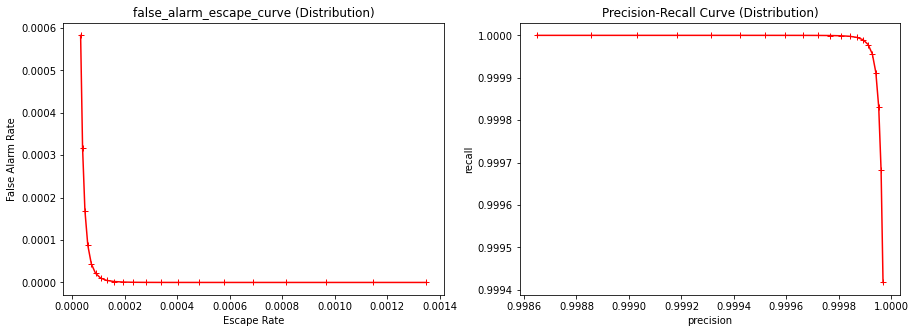

In [35]:
top, bottom, left, right  = 0, 255, 50, -25
crop_dims = (top, bottom, left, right)
nominal_loss_list = process_images(nominal_test_images, (top, bottom, left, right))  
anomaly_loss_list = process_images(anomalous_all_images, (top, bottom, left, right))
    
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5) )
ax0, ax1 = axes.flatten()

false_alarm_escape_curve(nominal_loss_list, anomaly_loss_list, ax0)
plot_precision_recall_curve(nominal_loss_list, anomaly_loss_list, ax1)


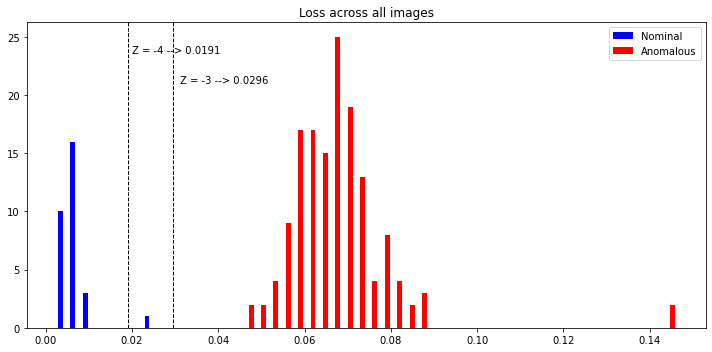

In [38]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax = axes # ax = axes.flatten()

data = [nominal_loss_list, anomaly_loss_list]
bins = 50
colors = ["blue","red"]
labels = ["Nominal", "Anomalous"]
ax.hist(data, bins, histtype='bar', color=colors, label=labels)

thresh = 0.0191
ax.axvline(thresh, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(thresh*1.05, max_ylim*0.9, 'Z = -4 --> {:.4f}'.format(thresh))

thresh = 0.0296
ax.axvline(thresh, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(thresh*1.05, max_ylim*0.8, 'Z = -3 --> {:.4f}'.format(thresh))

ax.set_title('Loss across all images')
ax.legend(prop={'size': 10})

fig.tight_layout()

plt.show()



# Conclusion
### Proof of concept for a generalized defect detector?
We've certainly demonstrated viability, with 2 clearly distinct distributions, we've succeeded in detected the differences in these images

### Appropriate for safety critical applications?
Yes, mostly. This model is seeing 2% false alarm rates. That means we've reduced 98% of the manual work with this general application. We could still improve further, but this is arguably ready for use. 

### Appropriate for finding visual defects (not safety critical)?
Absolutely. Setting a threshold of .0296, this model finds 99.9% of issues, with only 0.02% false alarm rate. 

# See readme for next steps in this project...
There are a handful of features that would be fun to explore, but this satisfies the original scope of this project.